In [1905]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
from scipy.special import logsumexp
import math

In [1906]:
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
print(weekly_covid_df.head())

pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))

        date  confirmed_cases  confirmed_deaths
0 2020-02-23              4.0               0.0
1 2020-03-01             23.0               0.0
2 2020-03-08            131.0               0.0
3 2020-03-15            624.0               0.0
4 2020-03-22           1152.0               6.0
Total Population:  126014024
0.01% of Population:  126014


In [1919]:
YO.shape

(202,)

In [1907]:
# Initial Value Conditions Prior
def set_IVC(N, num_particles):
    R = np.zeros(num_particles)
    I = stats.uniform(0,100).rvs(num_particles)
    S = np.ones(num_particles) * N - I
    
    beta = stats.uniform(0,100).rvs(num_particles)
    
    return np.vstack([S, I, R, beta])

def set_param_priors():
    alpha = stats.uniform(0,1).rvs()
    gamma = stats.uniform(0,1).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(50,scale=100).rvs()
    
    return [alpha, gamma, sigma_b, psi_o]

In [1908]:
def BM_SEUORDS(X_in, params, num_particles, N):
    # Initialize arrays to store results
    X = np.zeros([X_in.shape[0], num_particles])
    Z1 = np.zeros([num_particles])
    
    new_infected = np.zeros([num_particles])

    # Set initial conditions
    gamma, sigma_b, _ = params

    # Update beta(t) using Euler-Maruyama
    Z1[:] = np.log(X_in[3, :]) + sigma_b * stats.norm(0, 1).rvs(num_particles)
    X[3, :] = np.exp(Z1[:])
    
    # Update SEUORDS model
    X[0, :] = X_in[0, :] - X_in[3, :] * X_in[0, :]*X_in[1, :]/N                           # S-Susceptibles
    X[1, :] = X_in[1, :] + X_in[3, :] * X_in[0, :]*X_in[1, :]/N - gamma * X_in[1, :]      # I-Infected
    X[2, :] = X_in[2, :] + gamma * X_in[1, :]                                             # R-Recovered
    
    new_infected =  X_in[3, :] * X_in[0, :]*X_in[1, :]/N
    
    return X, new_infected

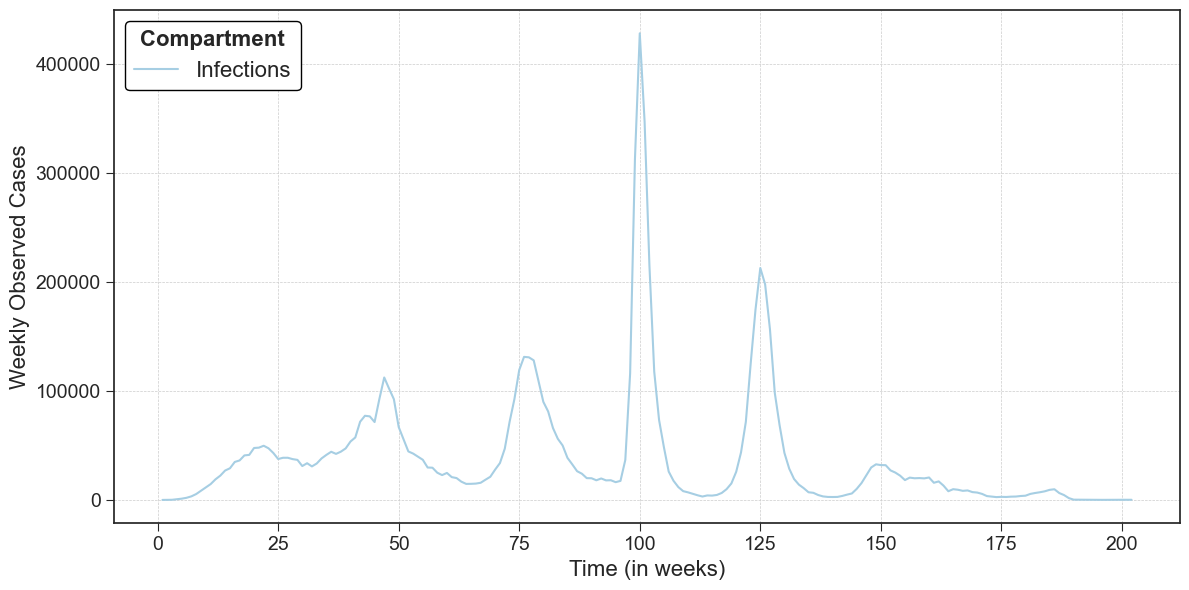

In [1909]:
# Define subset of data to run the algorithm 
weeks = 202

YO = weekly_covid_df['confirmed_cases'].values[:weeks]

time = np.linspace(1, weeks, weeks)

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, YO, color=colors[0], label='Infections')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [1920]:
T =  weeks - 1
num_particles = 5000

params = set_param_priors()
initial_conditions = set_IVC(N, num_particles)

In [1924]:
# Initialize PF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])

weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])

ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]

weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ESS[0] = num_particles

ancestry_matrix[:,0] = np.arange(num_particles)


for t in range(1,T+1):
    # Propagate particles to next week
    particles[:,:,t], weekly_infections[:,t] = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), t-1], params, num_particles, N)

    # Update particle weights and resample
    incremental_weights = stats.nbinom(n=1/0.1, p=1/(1+0.1*weekly_infections[:,t])).logpmf(YO[t+1])
    print(t)
    print(YO[t+1])

    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)

    if np.isnan(loglikelihood):
        break

    # Systematic resampling
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t]), positions)
    ancestry_matrix[:,1:t-1] = ancestry_matrix[resample_indices,1:t-1]
    ancestry_matrix[:,t] = resample_indices
    
print(loglikelihood)

1
131.0
2
624.0
3
1152.0
4
1955.0
5
3272.0
6
5395.0
7
8456.0
8
11548.0
9
14529.0
10
18884.0
11
22282.0
12
26951.0
13
29019.0
14
34820.0
15
36209.0
16
40819.0
17
41295.0
18
47625.0
19
47925.0
20
49680.0
21
47331.0
22
43022.0
23
37497.0
24
38650.0
25
38660.0
26
37412.0
27
36712.0
28
31070.0
29
33661.0
30
30719.0
31
33400.0
32
38055.0
33
41290.0
34
44152.0
35
42213.0
36
44240.0
37
47233.0
38
53543.0
39
57281.0
40
71701.0
41
77156.0
42
76613.0
43
71391.0
44
92734.0
45
112257.0
46
102089.0
47
92363.0
48
66811.0
49
55579.0
50
44464.0
51
42477.0
52
39584.0
53
36800.0
54
29729.0
55
29537.0
56
24963.0
57
22769.0
58
24752.0
59
20918.0
60
20038.0
61
16724.0
62
14692.0
63
14760.0
64
14982.0
65
15724.0
66
18535.0
67
21222.0
68
27791.0
69
33802.0
70
46962.0
71
71580.0
72
92452.0
73
119167.0
74
131161.0
75
130753.0
76
127979.0
77
108960.0
78
89902.0
79
81091.0
80
65895.0
81
56072.0
82
49923.0
83
38592.0
84
32591.0
85
26348.0
86
24016.0
87
19983.0
88
19867.0
89
18008.0
90
19669.0
91
17919.0
92
18040.0

IndexError: index 202 is out of bounds for axis 0 with size 202

In [2360]:
# Initialize PF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T]) 
weekly_infections = np.zeros([num_particles, T])
infected_trajectories = np.zeros([num_particles, T])

weights = np.zeros([num_particles, T])
norm_weights = np.zeros([num_particles, T])

ancestry_matrix = np.zeros([num_particles, T])
ESS = np.zeros(T)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[1, :, 0]

incremental_weights = NB_log_likelihood(YO[0], weekly_infections[:,0], params[3])
max_weights = np.max(incremental_weights)
weights[:,0] = np.exp(incremental_weights - max_weights)
sum_weights = weights[:,0].sum()
norm_weights[:,0] = weights[:,0] / sum_weights
    
ESS[0] = 1 / (np.sum(norm_weights[:,0]**2))
loglikelihood += max_weights + np.log(np.sum(weights[:,0])) - np.log(num_particles)

# Systematic resampling at time t=0
r = stats.uniform(0,1).rvs()
positions =  (np.arange(num_particles) + r )/num_particles
resample_indices = np.searchsorted(np.cumsum(norm_weights[:,0]), positions)
ancestry_matrix[:,0] = resample_indices

infected_trajectories[:,0] = weekly_infections[ancestry_matrix[:,0].astype(int),0]

for t in range(1,T):
    # Propagate particles to next week
    particles[:,:,t], weekly_infections[:,t] = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), t-1], params, num_particles, N)
    
    # Update particle weights and resample
    incremental_weights = NB_log_likelihood(YO[t], weekly_infections[:,t], params[3])
    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    
    if np.isnan(loglikelihood):
        break
    
    # Systematic resampling
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t]), positions)
    ancestry_matrix[:,t] = resample_indices
    
    infected_trajectories[:,t] = weekly_infections[ancestry_matrix[:,t].astype(int),t]    
    
print(loglikelihood)

-19722.62542732716


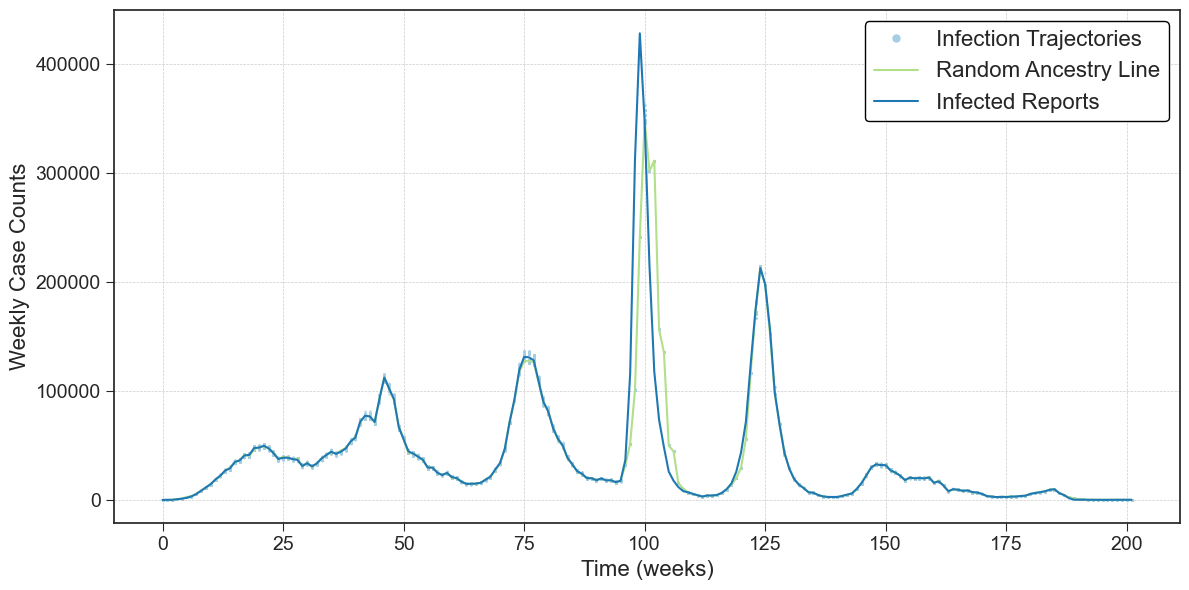

In [2361]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(infected_trajectories[0,:], marker='o', linewidth=0, color=colors[0], label='Infection Trajectories', markersize=0.5)
for p in range(1, num_particles):
    plt.plot(infected_trajectories[p,:], marker='o', linewidth=0, color=colors[0], markersize=0.5)
plt.plot(infected_trajectories[np.random.choice(np.array(num_particles),1,p=norm_weights[:,-1])[0],:], color=colors[2], label='Random Ancestry Line')
plt.plot(YO, color= colors[1], label='Infected Reports')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=10)
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Case Counts', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

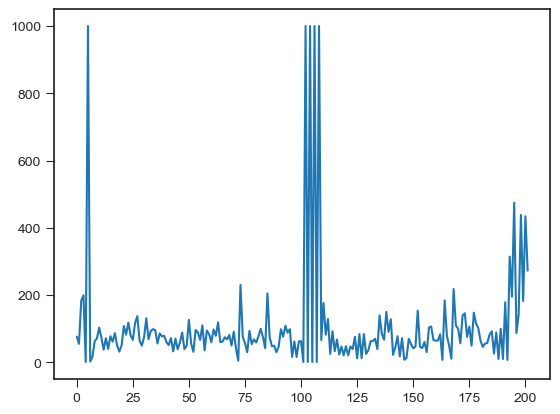

In [2362]:
plt.plot(ESS)

In [2363]:
def particle_filter(YO, N, T, num_particles, params, initial_conditions, BM_SEUORDS, NB_log_likelihood):
    # Initialize PF variables
    particles = np.zeros([initial_conditions.shape[0], num_particles, T]) 
    weekly_infections = np.zeros([num_particles, T])
    infected_trajectories = np.zeros([num_particles, T])

    weights = np.zeros([num_particles, T])
    norm_weights = np.zeros([num_particles, T])

    ancestry_matrix = np.zeros([num_particles, T])
    ESS = np.zeros(T)
    loglikelihood = 0

    # Define values at time t=0
    particles[:, :, 0] = initial_conditions
    weekly_infections[:,0] = particles[1, :, 0]

    incremental_weights = NB_log_likelihood(YO[0], weekly_infections[:,0], params[3])
    max_weights = np.max(incremental_weights)
    weights[:,0] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,0].sum()
    norm_weights[:,0] = weights[:,0] / sum_weights
        
    ESS[0] = 1 / (np.sum(norm_weights[:,0]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,0])) - np.log(num_particles)

    # Systematic resampling at time t=0
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,0]), positions)
    ancestry_matrix[:,0] = resample_indices

    infected_trajectories[:,0] = weekly_infections[ancestry_matrix[:,0].astype(int),0]

    for t in range(1,T):
        # Propagate particles to next week
        particles[:,:,t], weekly_infections[:,t] = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), t-1], params, num_particles, N)
        
        # Update particle weights and resample
        incremental_weights = NB_log_likelihood(YO[t], weekly_infections[:,t], params[3])
        max_weights = np.max(incremental_weights)
        weights[:,t] = np.exp(incremental_weights - max_weights)
        sum_weights = weights[:,t].sum()
        norm_weights[:,t] = weights[:,t] / sum_weights
        
        ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
        loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
        
        if np.isnan(loglikelihood):
            break
        
        # Systematic resampling
        r = stats.uniform(0,1).rvs()
        positions =  (np.arange(num_particles) + r )/num_particles
        resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t]), positions)
        ancestry_matrix[:,t] = resample_indices
        
        infected_trajectories[:,t] = weekly_infections[ancestry_matrix[:,t].astype(int),t]
        
    return loglikelihood, infected_trajectories[np.random.choice(np.array(num_particles),1,p=np.ones(num_particles)/num_particles),:]#   norm_weights[:, -1]),:]
        

In [2364]:
num_particles = 50000
params = set_param_priors()
initial_conditions = set_IVC(N, num_particles)

test1, test2 = particle_filter(YO, N, T, num_particles, params, initial_conditions, BM_SEUORDS, NB_log_likelihood)

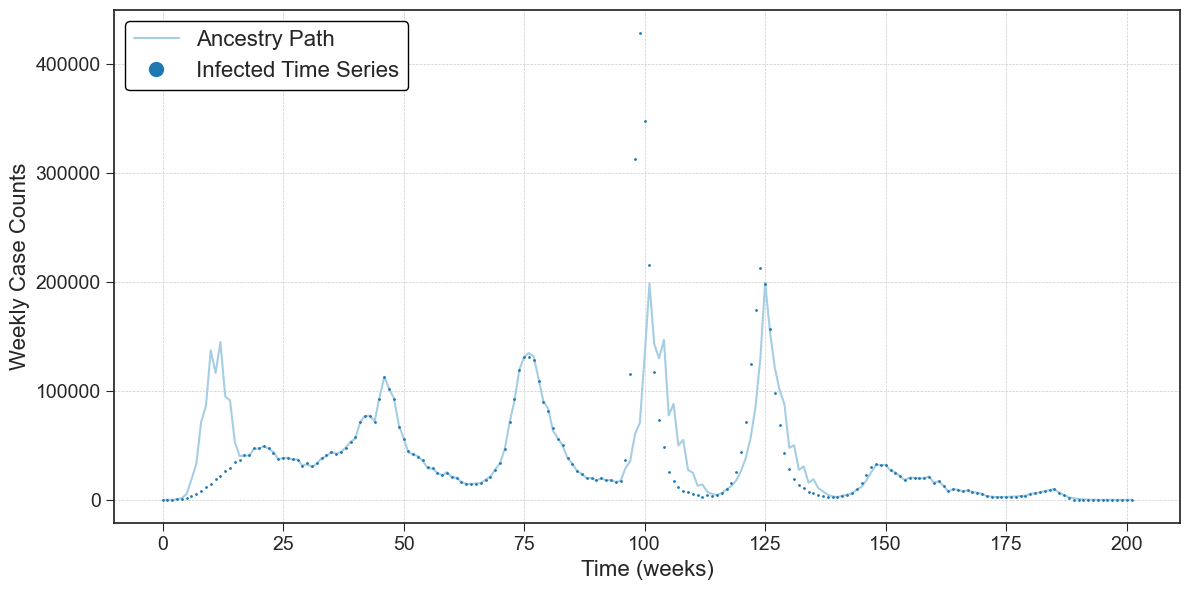

In [2367]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(test2[0,:], color=colors[0], label='Ancestry Path')
plt.plot(YO, color=colors[1], linewidth=0, marker='o', markersize=1, label='Infected Time Series')
plt.legend(
    loc='upper left',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=10)
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Case Counts', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [750]:
def logprior(theta):
    alpha, gamma, sigma_b, psi_o = theta
    if (alpha < 0 or alpha > 1 or 
        gamma < 0 or gamma > 1 or 
        sigma_b < 0 or 
        psi_o < 0):
        return -np.inf
    else:
        logprior = stats.beta(2.3, 96.5).logpdf(alpha) 
        logprior += stats.beta(2.36, 9.44).logpdf(gamma)
        logprior += stats.invgamma(a=3.8, scale=0.6).logpdf(sigma_b)
        logprior += stats.gamma(50,scale=100).logpdf(psi_o)
        
    return logprior

In [909]:
num_iterations = 5000
num_particles = 100000
initial_conditions = set_IVC(N, num_particles)

sigma0 = np.diag([
    0.0000000001,
    0.0000000001,
    0.0000000001,
    0.0000000001
    ])

In [910]:
theta_samples = []
loglikelihoods = []
weekly_trajectories = []
parameter_trajectories = []
acceptance_count = 0
AccRate = 0
rejected_count = 0

# Loop to find viable starting parameters
while True:
    current_theta = set_param_priors()  # Sample initial parameters
    current_loglik, current_weekly  = particle_filter(YO, N, T, num_particles, current_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)
    
    # Check if the log-likelihood is valid
    if not np.isnan(current_loglik) and np.isfinite(current_loglik):  # Ensure log-likelihood is finite and not NaN
        break  # Exit the loop when valid parameters are found
    
print("Initial viable parameters:", current_theta)
print("Initial log-likelihood:", current_loglik)

loglikelihoods.append(current_loglik)
theta_samples.append(current_theta)
weekly_trajectories.append(current_weekly)
parameter_trajectories.append(current_theta)

for i in range(num_iterations):
    proposed_theta = current_theta + stats.multivariate_normal(mean=np.zeros(4), cov=sigma0).rvs()
    if np.isinf(logprior(proposed_theta)):
        rejected_count += 1
        proposed_loglik = -np.inf
        accept_prob = 0
    else:
        proposed_loglik, current_weekly = particle_filter(YO, N, T, num_particles, proposed_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)
        accept_prob = min(1, np.exp(proposed_loglik - current_loglik + logprior(proposed_theta) - logprior(current_theta)))
        # print('proposed loglik', proposed_loglik)
        # print('current loglik', current_loglik)
        # print('prior proposed', logprior(proposed_theta))
        # print('current proposed', logprior(current_theta))

    
    if stats.uniform.rvs() < accept_prob:
            current_theta = proposed_theta
            current_loglik = proposed_loglik
            acceptance_count += 1
    
    loglikelihoods.append(current_loglik)
    theta_samples.append(current_theta) 
    weekly_trajectories.append(current_weekly)
        
    AccRate = acceptance_count / (i + 1)
    if i % 10 == 0:
        print(f"Iteration {i}: Acceptance Rate = {AccRate:.2%}")
        print('Unique Samples: ', np.unique(loglikelihoods).shape[0])
        print('Rejected Samples: ', rejected_count)
        print('proposed loglik', proposed_loglik)
        print('current loglik', current_loglik)
        print('prior proposed', logprior(proposed_theta))
        print('current proposed', logprior(current_theta))

Initial viable parameters: [np.float64(0.682136693878338), np.float64(0.7671060196150039), np.float64(0.2573653694473476), np.float64(4793.278794557105)]
Initial log-likelihood: -1943.4297003378226
Iteration 0: Acceptance Rate = 100.00%
Unique Samples:  2
Rejected Samples:  0
proposed loglik -1929.5094614126033
current loglik -1929.5094614126033
prior proposed -113.7588852323814
current proposed -113.7588852323814
Iteration 10: Acceptance Rate = 27.27%
Unique Samples:  4
Rejected Samples:  0
proposed loglik -1961.6762105600465
current loglik -1927.2652678348998
prior proposed -113.75494497703765
current proposed -113.754537642341
Iteration 20: Acceptance Rate = 14.29%
Unique Samples:  4
Rejected Samples:  0
proposed loglik -1933.997265802006
current loglik -1927.2652678348998
prior proposed -113.75706211732953
current proposed -113.754537642341
Iteration 30: Acceptance Rate = 12.90%
Unique Samples:  5
Rejected Samples:  0
proposed loglik -1938.1653375262556
current loglik -1926.1947055

KeyboardInterrupt: 

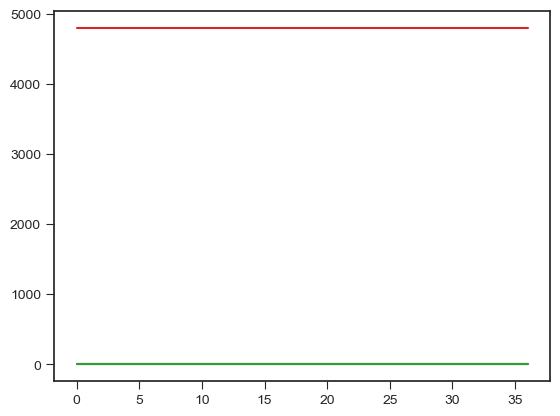

In [914]:
plt.plot(np.array(theta_samples[:])[:,:4])

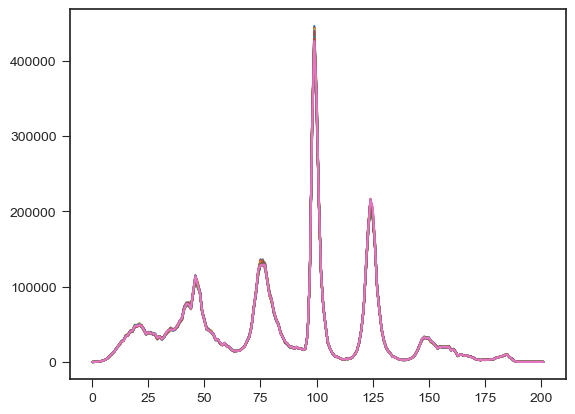

In [918]:
for t in range(np.array(weekly_trajectories).shape[0]):
    plt.plot(np.array(weekly_trajectories)[t,0,:])

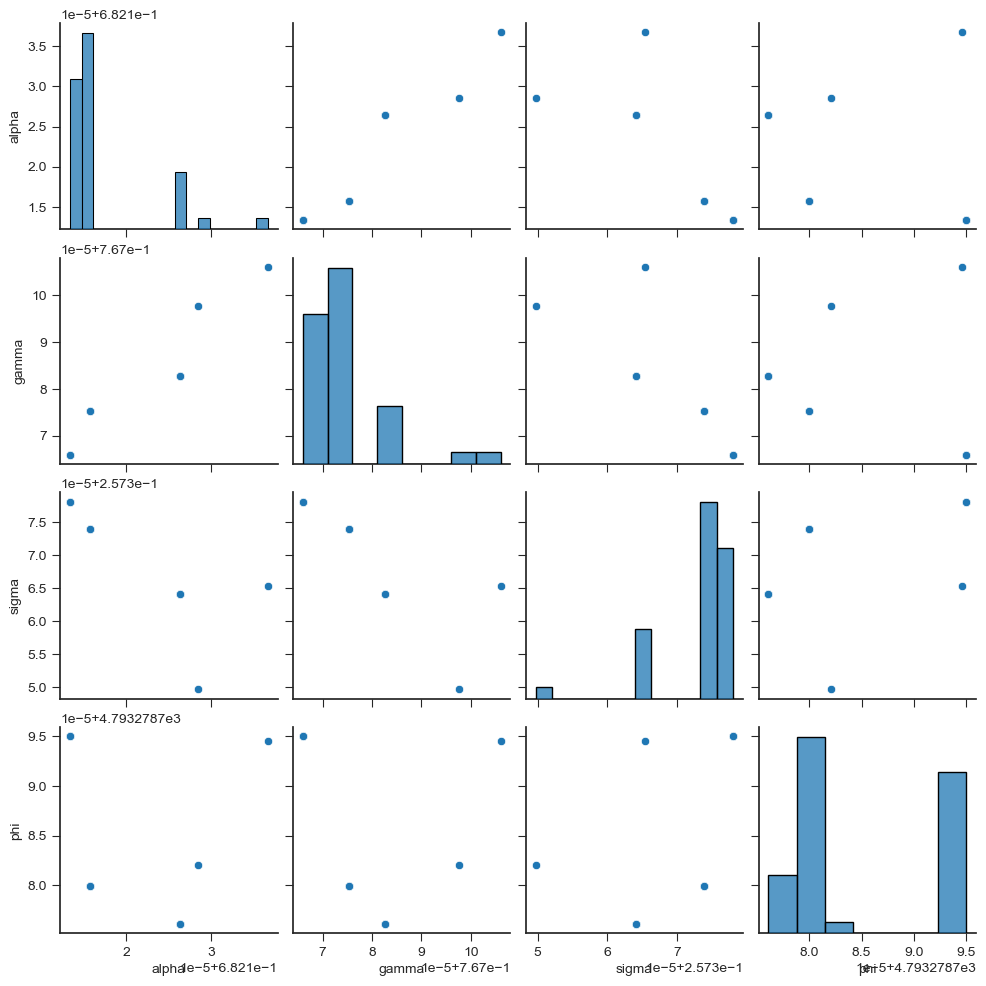

In [919]:
# Convert to DataFrame with column names
df = pd.DataFrame(theta_samples, columns=['alpha', 'gamma', 'sigma', 'phi'])
sns.pairplot(df)

In [920]:
np.cov(np.array(theta_samples).T)

array([[ 3.20801546e-11,  4.59197973e-11, -3.04465188e-11,
        -1.73883103e-11],
       [ 4.59197973e-11,  7.81548339e-11, -4.70720561e-11,
        -3.62238084e-11],
       [-3.04465188e-11, -4.70720561e-11,  3.74054199e-11,
         2.69621450e-11],
       [-1.73883103e-11, -3.62238084e-11,  2.69621450e-11,
         6.20165922e-11]])

### AUXILIARY PARTICLE FILTER

In [2368]:
# Initial Value Conditions Prior
def set_IVC(N, num_particles):
    R = np.zeros(num_particles)
    I = stats.uniform(0, 100).rvs(num_particles)
    S = np.ones(num_particles) * N - I
    
    beta = stats.uniform(0,100).rvs(num_particles)
    
    return np.vstack([S, I, R, beta])

def set_param_priors():
    alpha = stats.uniform(0,1).rvs()
    gamma = stats.uniform(0,1).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(50,scale=100).rvs()
    
    return [alpha, gamma, sigma_b, psi_o]

In [2385]:
num_particles = 10000
params = set_param_priors()
initial_conditions = set_IVC(N, num_particles)
T=weeks

In [2405]:
# Initialize PF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T]) 
weekly_infections = np.zeros([num_particles, T])

norm_primary_weights = np.zeros([num_particles, T])
norm_secondary_weights = np.zeros([num_particles, T])

ancestry_matrix = np.zeros([num_particles, T])
ESS = np.zeros(T)
loglikelihood = 0

# TIME t=1
# Primary Weights
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[1, :, 0]

incremental_weights = NB_log_likelihood(YO[0], weekly_infections[:,0], params[3])
norm_primary_weights[:,0] = np.exp(incremental_weights - logsumexp(incremental_weights))

ESS[0] = 1 / (np.sum(norm_primary_weights[:,0]**2))
loglikelihood += logsumexp(incremental_weights) - np.log(num_particles)

# Secondary Weights
propagated_particles, propagated_infections = BM_SEUORDS(particles[:, :, 0], params, num_particles, N)
incremental_weights = NB_log_likelihood(YO[1], propagated_infections, params[3])
log_sum_exp = logsumexp(incremental_weights + np.log(norm_primary_weights[:,0]))
norm_secondary_weights[:,0] = np.exp(incremental_weights + np.log(norm_primary_weights[:,0]) - log_sum_exp)

# Systematic resampling
r = stats.uniform(0,1).rvs()
positions =  (np.arange(num_particles) + r )/num_particles
resample_indices = np.searchsorted(np.cumsum(norm_secondary_weights[:,0]), positions)
ancestry_matrix[:,0] = resample_indices
weekly_infections[:,0] = weekly_infections[resample_indices.astype(int),0] 
norm_secondary_weights[:,0] = np.ones(num_particles)/num_particles

for t in range(1,T-1):
    # Primary Weights
    particles[:,:,t], weekly_infections[:,t] = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), t-1], params, num_particles, N)
    incremental_weights = NB_log_likelihood(YO[t], weekly_infections[:,t], params[3])
    log_unnormalized_weights = np.log(norm_primary_weights[:, t-1]+1e-12) - np.log(norm_secondary_weights[:, t-1]+1e-12) + incremental_weights
    norm_primary_weights[:, t] = np.exp(log_unnormalized_weights - logsumexp(log_unnormalized_weights))

    ESS[t] = 1 / (np.sum(norm_primary_weights[:,t]**2))
    loglikelihood += logsumexp(log_unnormalized_weights) - np.log(num_particles)
            
    # Secondary Weights
    propagated_particles, propagated_infections = BM_SEUORDS(particles[:, :, t], params, num_particles, N)
    incremental_weights = NB_log_likelihood(YO[t+1], propagated_infections, params[3])
    log_sum_exp = logsumexp(incremental_weights + np.log(norm_primary_weights[:,t]))
    norm_secondary_weights[:,t] = np.exp(incremental_weights + np.log(norm_primary_weights[:,t]) - log_sum_exp)
    
    # Systematic resampling
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_secondary_weights[:,t]), positions)
    ancestry_matrix[:,t] = resample_indices
    weekly_infections[:,t] = weekly_infections[resample_indices.astype(int),t] 

# TIME t=T
# Primary Weights
particles[:,:,T-1], weekly_infections[:,T-1] = BM_SEUORDS(particles[:, ancestry_matrix[:,T-2].astype(int), T-2], params, num_particles, N)
incremental_weights = NB_log_likelihood(YO[T-1], weekly_infections[:,T-1], params[3])
log_unnormalized_weights = np.log(norm_primary_weights[:, T-2]+1e-12) - np.log(norm_secondary_weights[:, T-2]+1e-12) + incremental_weights
norm_primary_weights[:, T-1] = np.exp(log_unnormalized_weights - logsumexp(log_unnormalized_weights))

ESS[T-1] = 1 / (np.sum(norm_primary_weights[:,T-1]**2))
loglikelihood += logsumexp(log_unnormalized_weights) - np.log(num_particles)

print(loglikelihood)

-832.0558692877411


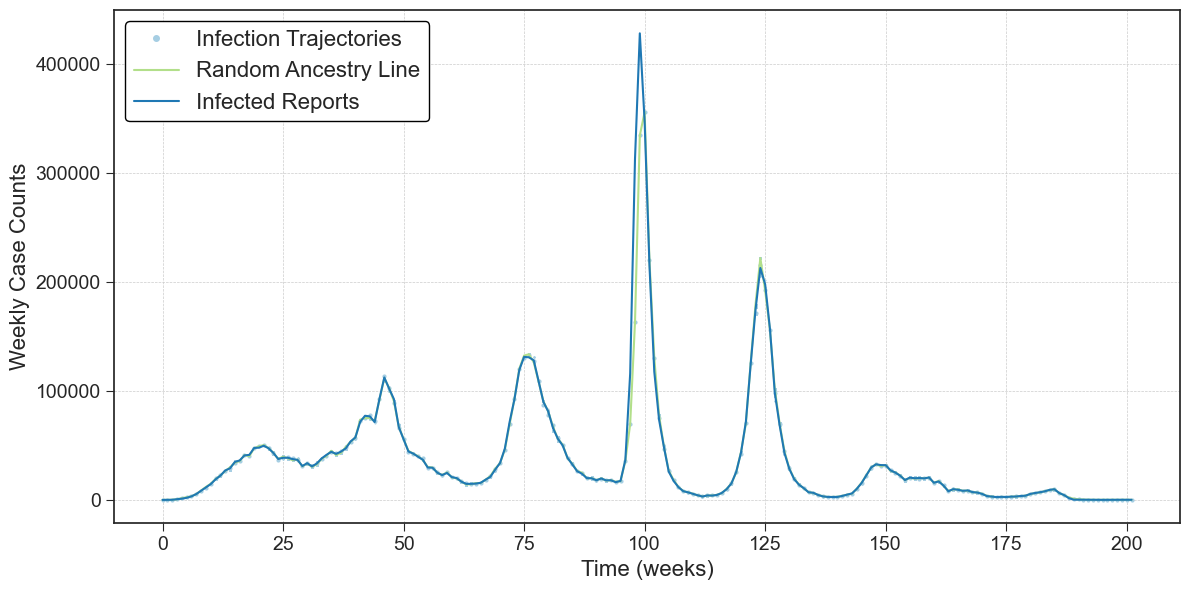

In [2406]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(weekly_infections[0,:], marker='o', linewidth=0, color=colors[0], label='Infection Trajectories', markersize=2)
for p in range(1, num_particles):
    plt.plot(weekly_infections[p,:], marker='o', linewidth=0, color=colors[0], markersize=0.5)
plt.plot(weekly_infections[np.random.choice(np.array(num_particles),1,p=np.ones(num_particles)/num_particles)[0],:], color=colors[2], label='Random Ancestry Line')
plt.plot(YO, color= colors[1], label='Infected Reports')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=2)
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Case Counts', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

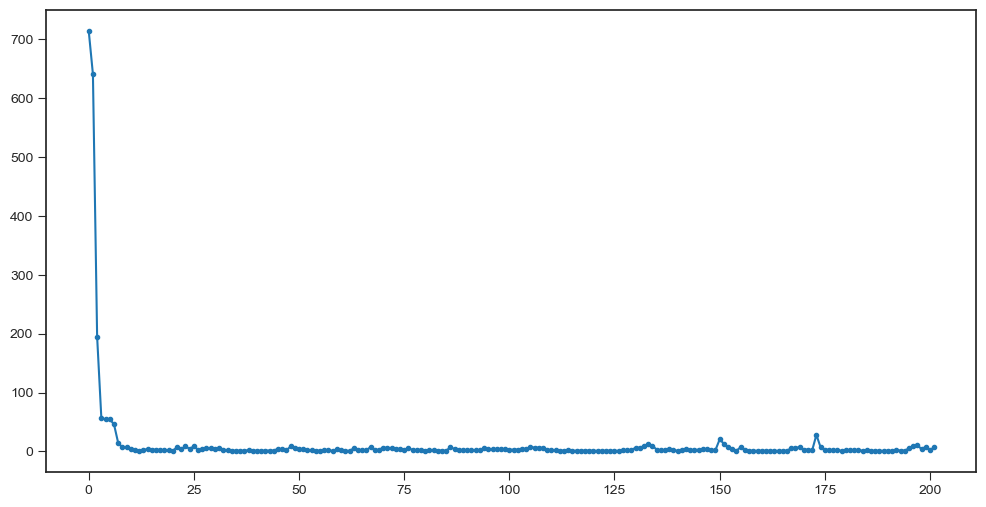

In [2409]:
plt.figure(figsize=(12,6))
plt.plot(ESS, marker='o', markersize=3)

In [2410]:
def ASIR(YO, N, T, num_particles, params, initial_conditions, BM_SEUORDS, NB_log_likelihood):
    # Initialize PF variables
    particles = np.zeros([initial_conditions.shape[0], num_particles, T]) 
    weekly_infections = np.zeros([num_particles, T])

    norm_primary_weights = np.zeros([num_particles, T])
    norm_secondary_weights = np.zeros([num_particles, T])

    ancestry_matrix = np.zeros([num_particles, T])
    ESS = np.zeros(T)
    loglikelihood = 0
    
    # TIME t=1
    # Primary Weights
    particles[:, :, 0] = initial_conditions
    weekly_infections[:,0] = particles[1, :, 0]

    incremental_weights = NB_log_likelihood(YO[0], weekly_infections[:,0], params[3])
    norm_primary_weights[:,0] = np.exp(incremental_weights - logsumexp(incremental_weights))

    ESS[0] = 1 / (np.sum(norm_primary_weights[:,0]**2))
    loglikelihood += logsumexp(incremental_weights) - np.log(num_particles)

    # Secondary Weights
    propagated_particles, propagated_infections = BM_SEUORDS(particles[:, :, 0], params, num_particles, N)
    incremental_weights = NB_log_likelihood(YO[1], propagated_infections, params[3])
    log_sum_exp = logsumexp(incremental_weights + np.log(norm_primary_weights[:,0]))
    norm_secondary_weights[:,0] = np.exp(incremental_weights + np.log(norm_primary_weights[:,0]) - log_sum_exp)

    # Systematic resampling
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_secondary_weights[:,0]), positions)
    ancestry_matrix[:,0] = resample_indices
    weekly_infections[:,0] = weekly_infections[resample_indices.astype(int),0] 

    for t in range(1,T-1):
        # Primary Weights
        particles[:,:,t], weekly_infections[:,t] = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), t-1], params, num_particles, N)
        incremental_weights = NB_log_likelihood(YO[t], weekly_infections[:,t], params[3])
        log_unnormalized_weights = np.log(norm_primary_weights[:, t-1]+1e-12) - np.log(norm_secondary_weights[:, t-1]+1e-12) + incremental_weights
        norm_primary_weights[:, t] = np.exp(log_unnormalized_weights - logsumexp(log_unnormalized_weights))

        ESS[t] = 1 / (np.sum(norm_primary_weights[:,t]**2))
        loglikelihood += logsumexp(log_unnormalized_weights) - np.log(num_particles)
                
        # Secondary Weights
        propagated_particles, propagated_infections = BM_SEUORDS(particles[:, :, t], params, num_particles, N)
        incremental_weights = NB_log_likelihood(YO[t+1],propagated_infections, params[3])
        log_sum_exp = logsumexp(incremental_weights + np.log(norm_primary_weights[:,t]))
        norm_secondary_weights[:,t] = np.exp(incremental_weights + np.log(norm_primary_weights[:,t]) - log_sum_exp)
        
        # Systematic resampling
        r = stats.uniform(0,1).rvs()
        positions =  (np.arange(num_particles) + r )/num_particles
        resample_indices = np.searchsorted(np.cumsum(norm_secondary_weights[:,t]), positions)
        ancestry_matrix[:,t] = resample_indices
        weekly_infections[:,t] = weekly_infections[resample_indices.astype(int),t] 

    # TIME t=T
    # Primary Weights
    particles[:,:,T-1], weekly_infections[:,T-1] = BM_SEUORDS(particles[:, ancestry_matrix[:,T-2].astype(int), T-2], params, num_particles, N)
    incremental_weights = NB_log_likelihood(YO[T-1], weekly_infections[:,T-1], params[3])
    log_unnormalized_weights = np.log(norm_primary_weights[:, T-2]+1e-12) - np.log(norm_secondary_weights[:, T-2]+1e-12) + incremental_weights
    norm_primary_weights[:, T-1] = np.exp(log_unnormalized_weights - logsumexp(log_unnormalized_weights))

    ESS[T-1] = 1 / (np.sum(norm_primary_weights[:,T-1]**2))
    loglikelihood += logsumexp(log_unnormalized_weights) - np.log(num_particles)
    
    return loglikelihood, weekly_infections[np.random.choice(np.array(num_particles),1,p=norm_primary_weights[:, -1]),:][0]

In [2411]:
num_iterations = 1000
num_particles = 1000
initial_conditions = set_IVC(N, num_particles)
current_theta = np.array(set_param_priors())

sigma0 = np.eye(4)*1e-8

In [2412]:
theta_samples = np.zeros([current_theta.shape[0],num_iterations])
weekly_trajectories = np.zeros([T,num_iterations])
loglikelihoods = np.zeros(num_iterations)

rejected_count = 0
acceptance_count = 0
AccRate = 0

current_loglik, current_weekly  = ASIR(YO, N, T, num_particles, current_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)

print("Initial viable parameters:", current_theta)
print("Initial log-likelihood:", current_loglik)

theta_samples[:,0] = current_theta
loglikelihoods[0] = current_loglik
weekly_trajectories[:,0] = current_weekly

for i in range(1,num_iterations):
    proposed_theta = theta_samples[:, i-1] + stats.multivariate_normal(mean=np.zeros(4), cov=sigma0).rvs()
    if np.isinf(logprior(proposed_theta)):
        rejected_count += 1
        proposed_loglik = -np.inf
        accept_prob = 0
    else:
        proposed_loglik, proposed_weekly = ASIR(YO, N, T, num_particles, proposed_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)
        log_prior_ratio = logprior(proposed_theta) - logprior(theta_samples[:,i-1])
        log_lik_ratio = proposed_loglik - loglikelihoods[i-1]
        accept_prob = np.exp(min(0,log_prior_ratio + log_lik_ratio))
    
    if stats.uniform(0,1).rvs() <= accept_prob:
        theta_samples[:,i] = proposed_theta
        weekly_trajectories[:,i] = proposed_weekly
        loglikelihoods[i] = proposed_loglik
        acceptance_count += 1
    else:
        theta_samples[:,i] = theta_samples[:,i-1]
        weekly_trajectories[:,i] = weekly_trajectories[:,i-1]
        loglikelihoods[i] = loglikelihoods[i-1]
        
    AccRate = acceptance_count / (i + 1)
    if i % 100 == 0:
        print(f"Iteration {i}: Acceptance Rate = {AccRate:.2%}")
        print('Unique Samples: ', np.unique(loglikelihoods).shape[0])
        print('Rejected Samples: ', rejected_count)
        print('proposed loglik', proposed_loglik)
        print('current loglik', loglikelihoods[i-1])
        print('prior proposed', logprior(proposed_theta))
        print('current proposed', logprior(theta_samples[:,i-1]))

Initial viable parameters: [9.96586134e-01 7.27909481e-01 3.00899848e-01 5.98890582e+03]
Initial log-likelihood: 2371.1727067335064


KeyboardInterrupt: 

In [1975]:
current_theta = np.array(set_param_priors())

In [2008]:
max_num_particles = 100
particle_increments = 50


for i, num_particles in enumerate(range(particle_increments, max_num_particles + 1, particle_increments)):
    print(i)
    print(num_particles)


0
50
1
100


In [2413]:
particle_counts = np.array([100, 200, 300, 400, 500,1000])
aux_n = 30

loglikelihoods = np.zeros([particle_counts.shape[0],aux_n])
for i, num_particles in enumerate(particle_counts):
    print('Num particles: ',num_particles)
    initial_conditions = set_IVC(N, num_particles)
    for n in range(aux_n):
        loglikelihoods[i,n], _ = ASIR(YO, N, T, num_particles, current_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)

plt.plot(particle_counts[:6], np.var(loglikelihoods, axis=1)[:6])
plt.show()

Num particles:  100


KeyboardInterrupt: 

Num particles:  100
Num particles:  200


/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_7410/1223072927.py:16: RuntimeWarning: overflow encountered in multiply
  X[0, :] = X_in[0, :] - X_in[3, :] * X_in[0, :]*X_in[1, :]/N + alpha * X_in[2, :]        # S-Susceptibles
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_7410/1223072927.py:17: RuntimeWarning: overflow encountered in multiply
  X[1, :] = X_in[1, :] + X_in[3, :] * X_in[0, :]*X_in[1, :]/N - gamma * X_in[1, :]        # I-Infected
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_7410/1223072927.py:20: RuntimeWarning: overflow encountered in multiply
  new_infected =  X_in[3, :] * X_in[0, :]*X_in[1, :]/N
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_7410/1223072927.py:17: RuntimeWarning: invalid value encountered in subtract
  X[1, :] = X_in[1, :] + X_in[3, :] * X_in[0, :]*X_in[1, :]/N - gamma * X_in[1, :]        # I-Infected


Num particles:  300
Num particles:  400
Num particles:  500
Num particles:  1000


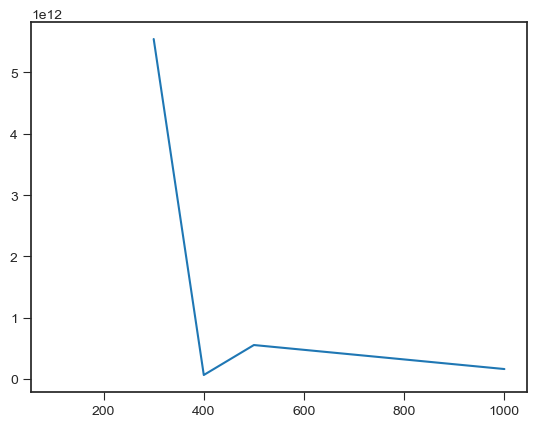

In [2123]:
particle_counts = np.array([100, 200, 300, 400, 500,1000])
aux_n = 30

loglikelihoods = np.zeros([particle_counts.shape[0],aux_n])
for i, num_particles in enumerate(particle_counts):
    print('Num particles: ',num_particles)
    initial_conditions = set_IVC(N, num_particles)
    for n in range(aux_n):
        loglikelihoods[i,n], _ = particle_filter(YO, N, T, num_particles, current_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)

plt.plot(particle_counts[:6], np.var(loglikelihoods, axis=1)[:6])
plt.show()

In [2085]:
grid_size = 11
num_particles = 1000
initial_conditions = set_IVC(N, num_particles)
aux_n = 50
alpha_loglikelihoods = np.zeros([grid_size, aux_n])

for i, param_values in enumerate(np.linspace(0,1,grid_size)):
    print('alpha = ', param_values)
    current_theta[0] = param_values
    for n in range(aux_n):
        alpha_loglikelihoods[i,n], _ = ASIR(YO, N, T, num_particles, current_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)

alpha =  0.0
alpha =  0.1
alpha =  0.2
alpha =  0.30000000000000004
alpha =  0.4
alpha =  0.5
alpha =  0.6000000000000001
alpha =  0.7000000000000001
alpha =  0.8
alpha =  0.9
alpha =  1.0


AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

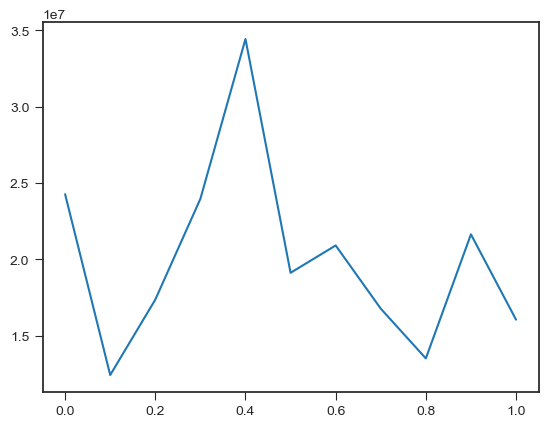

In [2093]:
plt.plot(np.linspace(0,1,grid_size), np.var(alpha_loglikelihoods, axis=1))
plt.label('alpha')
plt.show()

In [2092]:
grid_size = 11
num_particles = 1000
initial_conditions = set_IVC(N, num_particles)
aux_n = 50
gamma_loglikelihoods = np.zeros([grid_size, aux_n])

for i, param_values in enumerate(np.linspace(0,1,grid_size)):
    print('gamma = ', param_values)
    current_theta[1] = param_values
    for n in range(aux_n):
        gamma_loglikelihoods[i,n], _ = ASIR(YO, N, T, num_particles, current_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)

gamma =  0.0
gamma =  0.1
gamma =  0.2
gamma =  0.30000000000000004
gamma =  0.4
gamma =  0.5
gamma =  0.6000000000000001
gamma =  0.7000000000000001
gamma =  0.8
gamma =  0.9
gamma =  1.0


In [ ]:
def set_param_priors():
    alpha = stats.uniform(0,1).rvs()
    gamma = stats.uniform(0,1).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(50,scale=100).rvs()
    
    return [alpha, gamma, sigma_b, psi_o]

# Synthetic Data SMC Run

In [2227]:
def BM_SEIR(V_in, params, num_particles, N):
    # Initialize arrays to store results
    V = np.zeros([V_in.shape[0], num_particles])
    
    new_infected = np.zeros([num_particles])

    # Set initial conditions
    kappa, gamma, sigma_b, = params
    beta = np.exp(V_in[4,:])

    # Update beta(t) using Euler-Maruyama
    V[4,:] = V_in[4,:] + sigma_b * stats.norm(0, 1).rvs(num_particles)
    
    # Update SEUORDS model
    V[0, :] = V_in[0, :] - beta * V_in[0, :] * V_in[2, :] / N                                 # S-Susceptibles
    V[1, :] = V_in[1, :] + beta * V_in[0, :] * V_in[2, :] / N - kappa * V_in[1, :]            # E-Exposed
    V[2, :] = V_in[2, :] + kappa * V_in[1, :] - gamma * V_in[2, :]                            # I-Infected
    V[3, :] = V_in[3, :] + gamma * V_in[2, :]                                                 # R-Recovered
    
    new_infected =  kappa*V_in[1, :]
    
    return V, new_infected

In [2228]:
T = 100
num_particles = 1

N = 100000000
E0 = stats.uniform(100,1000).rvs(num_particles)
I0 = stats.uniform(10,100).rvs(num_particles)

V_in = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.ones(num_particles)*np.log(stats.uniform(1,5).rvs())
    ])

kappa = 1/4
gamma = 1/10
sigma_b = 0.35

params = [kappa, gamma, sigma_b]

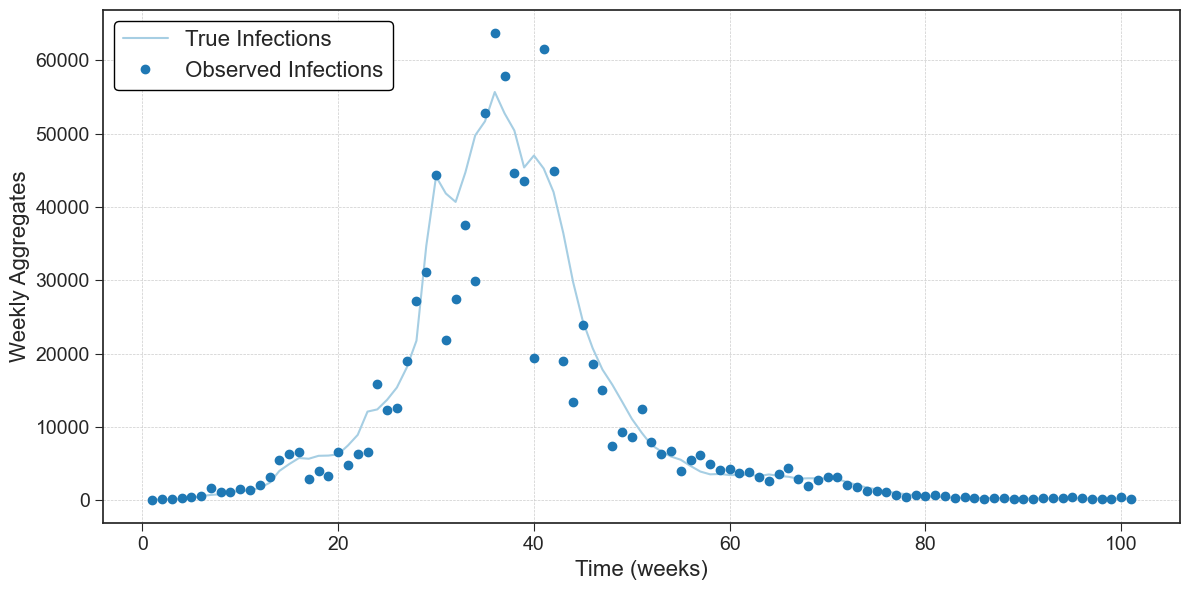

In [2235]:
# Initialize the arrays to store results
states = np.zeros([V_in.shape[0], num_particles, T+1])  
states[:, :, 0] = V_in 

aggregates = np.zeros([num_particles, T+1])
aggregates[:,0] = I0  

# Run the model over T periods with weekly aggregation
for t in range(1, T+1):
    states[:, :, t], aggregates[:, t] = BM_SEIR(states[:, :, t-1], params, num_particles, N)
    
# Define log-normal likelihood to add noise to obsrvations
Y_obs = stats.nbinom(n=1/0.1, p=1/(1+0.1*aggregates)).rvs()
#np.exp(stats.norm(np.log(aggregates[0,:]), 0.1).rvs())

# Plot the simulation for each particle
time = np.linspace(1, T+1, T+1)
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, aggregates[0,:], color=colors[0], label='True Infections')
plt.plot(time, Y_obs, color=colors[1], label='Observed Infections', marker='o', linewidth=0)
plt.legend(
    loc='upper left',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Aggregates', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

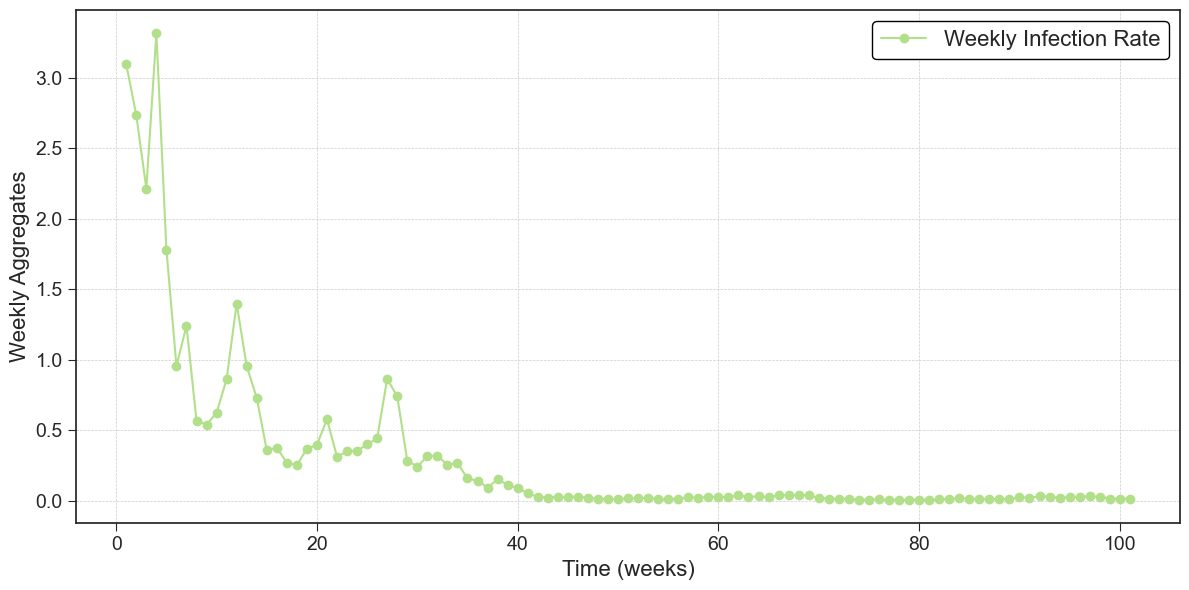

In [2236]:
time = np.linspace(1, T+1, T+1)
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')
    
plt.plot(time, np.exp(states[4,0,:]), 
         marker='o',
         color=colors[2], 
         label='Weekly Infection Rate')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Aggregates', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## BOOTSTRAP PARTICLE FILTER SOLUTION TO SYNTHETIC PROBLEM

In [2260]:
#Bootstrap Particle Filter
num_particles = 5000
# initial_conditions = np.repeat(V_in,num_particles).reshape(5,num_particles) #Sationary Initial Conditions
E0 = stats.uniform(100,1000).rvs(num_particles)
I0 = stats.uniform(10,100).rvs(num_particles)
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(1,5).rvs(num_particles))
    ])

# Initialize PF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])

estimates = np.zeros([2,T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])

ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]

weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ESS[0] = num_particles

ancestry_matrix[:,0] = np.arange(num_particles)
estimates[0,0] = np.sum(norm_weights[:,0]*weekly_infections[:,0])
estimates[1,0] = np.sum(norm_weights[:,0]*particles[-1,:,0])

for t in range(1,T+1):
    # Resample particles using Systematic Resampling
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t-1]), positions)
    ancestry_matrix[:,1:t-1] = ancestry_matrix[resample_indices,1:t-1]
    ancestry_matrix[:,t] = resample_indices
    
    # Propagate particles to next week
    particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:, resample_indices, t-1], params, num_particles, N)

    # Update particle weights
    incremental_weights = stats.nbinom(n=1/0.1, p=1/(1+0.1*weekly_infections[:,t])).logpmf(Y_obs[t])

    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    estimates[0,t] = np.sum(norm_weights[:,t]*weekly_infections[:,t])
    estimates[1,t] = np.sum(norm_weights[:,t]*particles[-1,:,t])

    if np.isnan(loglikelihood):
        break
    
print(loglikelihood)

-845.7780392655338


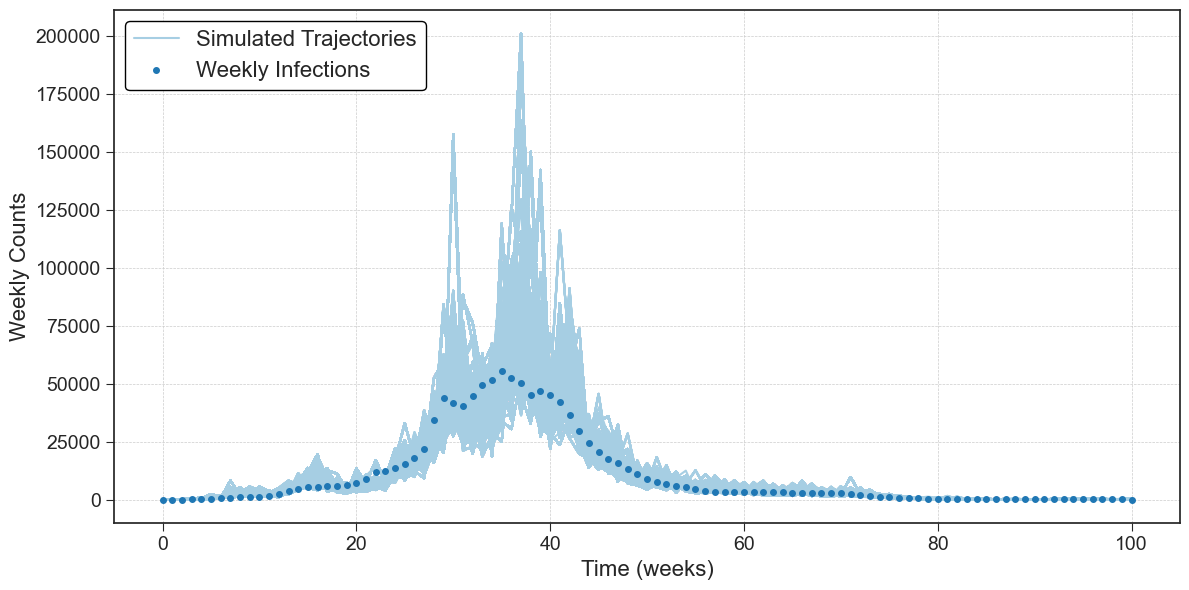

In [2261]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(1, num_particles):
    infected_trajectories = weekly_infections[ancestry_matrix[p, :].astype(int),np.arange(T+1)]
    plt.plot(infected_trajectories[:], color=colors[0])
infected_trajectories = weekly_infections[ancestry_matrix[0, :].astype(int),np.arange(T+1)]
plt.plot(infected_trajectories[:], color=colors[0], label='Simulated Trajectories')
plt.plot(aggregates[0,:], marker='o', markersize=4, linewidth=0, label='Weekly Infections')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Counts', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

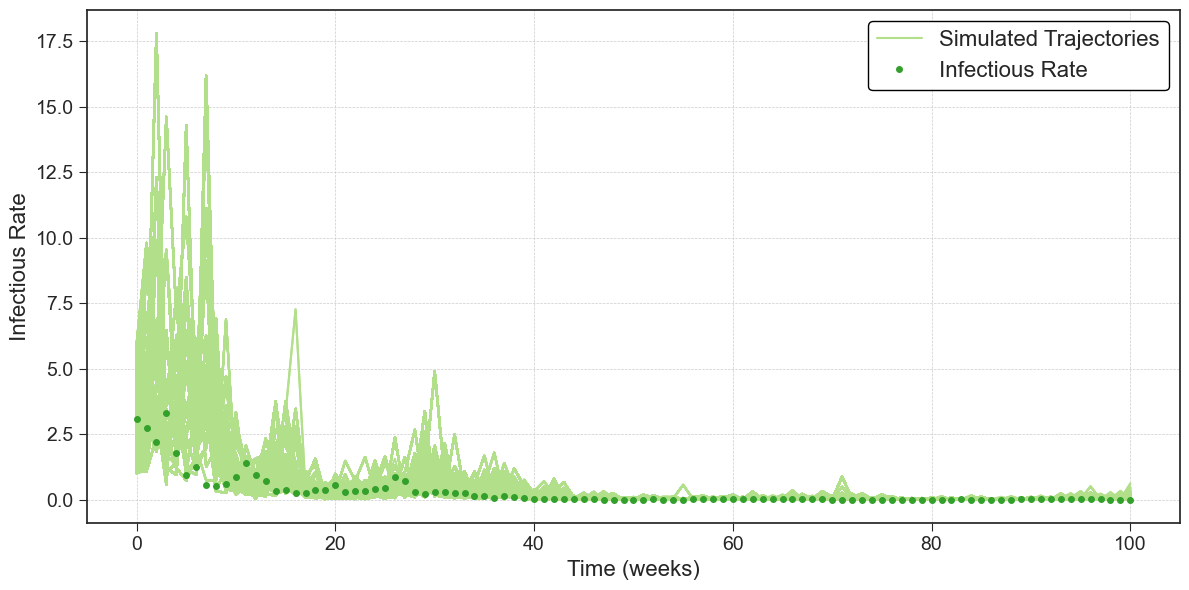

In [2262]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(1,num_particles):
    state_trajectories = particles[:,ancestry_matrix[p, :].astype(int),np.arange(T+1)]
    plt.plot(np.exp(state_trajectories[-1,:]), color=colors[2])

state_trajectories = particles[:,ancestry_matrix[0, :].astype(int),np.arange(T+1)]
plt.plot(np.exp(state_trajectories[-1,:]), color=colors[2], label='Simulated Trajectories')
    
plt.plot(np.exp(states[4,0,:]), marker='o', markersize=4, linewidth=0, color=colors[3], label='Infectious Rate')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Infectious Rate', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

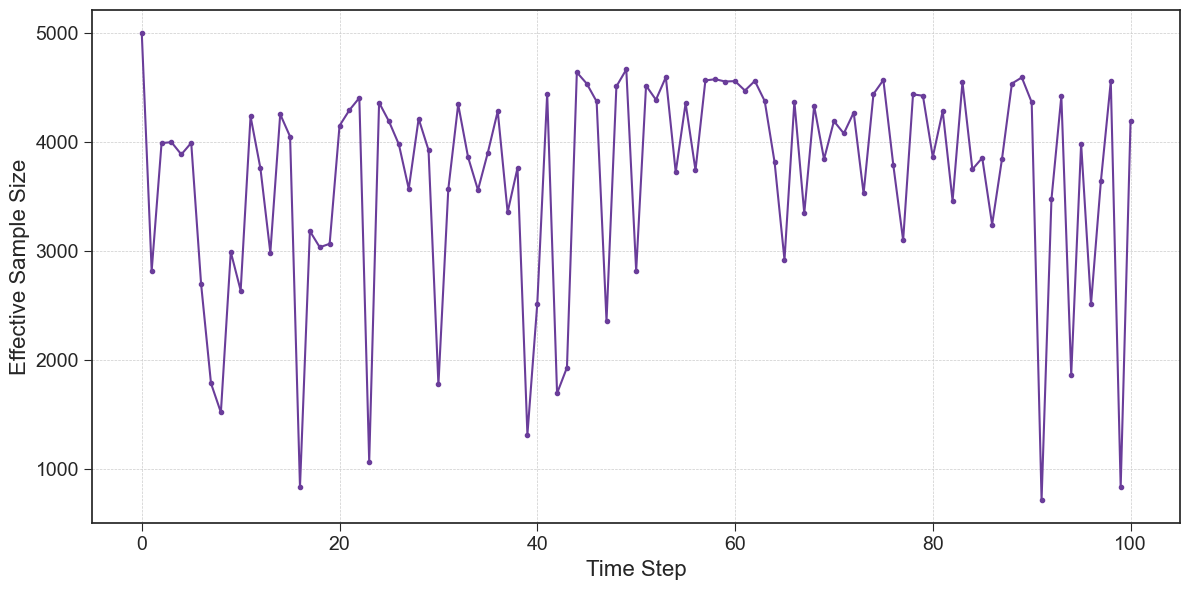

In [2263]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(ESS, marker='o', markersize=3, color=colors[-3])

plt.xlabel('Time Step', fontsize=16)
plt.ylabel('Effective Sample Size', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## AUXILIARY PARTICLE FILTER SOLUTION TO SYNTHETIC PROBLEM

In [2487]:
#Auxiliary Particle Filter
num_particles = 5000
# initial_conditions = np.repeat(V_in,num_particles).reshape(5,num_particles) #Sationary Initial Conditions
E0 = stats.uniform(100,1000).rvs(num_particles)
I0 = stats.uniform(10,100).rvs(num_particles)
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(1,5).rvs(num_particles))
    ])

# Initialize PF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])

estimates = np.zeros([2,T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])

aux_weights = np.zeros([num_particles, T+1])
norm_aux_weights = np.zeros([num_particles, T+1])

ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]

weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ESS[0] = num_particles

ancestry_matrix[:,0] = np.arange(num_particles)
estimates[0,0] = np.sum(norm_weights[:,0]*weekly_infections[:,0])
estimates[1,0] = np.sum(norm_weights[:,0]*particles[-1,:,0])

for t in range(1,T+1):
    # Resample Particles
    forward_particles, forward_infections = BM_SEIR(particles[:, :, t-1], params, num_particles, N)

    incremental_aux_weights = stats.nbinom(n=1/0.1, p=1/(1+0.1*np.mean(forward_infections))).logpmf(Y_obs[t])
    incremental_aux_weights += np.log(norm_weights[:,t-1])
    
    max_aux_weights = np.max(incremental_aux_weights)
    aux_weights[:,t] = np.exp(incremental_aux_weights - max_aux_weights)
    sum_aux_weights = aux_weights[:,t].sum()
    norm_aux_weights[:,t] = aux_weights[:,t] / sum_aux_weights
    
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_aux_weights[:,t]), positions)
    ancestry_matrix[:,1:t-1] = ancestry_matrix[resample_indices,1:t-1]
    ancestry_matrix[:,t] = resample_indices

    
    # Propagate particles to next week
    particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:, resample_indices, t-1], params, num_particles, N)

    # Update particle weights
    incremental_weights = stats.nbinom(n=1/0.1, p=1/(1+0.1*weekly_infections[:,t])).logpmf(Y_obs[t])
    incremental_weights += np.log(norm_weights[resample_indices,t-1]) - np.log(norm_aux_weights[resample_indices,t])
    
    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    if np.isnan(loglikelihood):
        break

    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    estimates[0,t] = np.sum(norm_weights[:,t]*weekly_infections[:,t])
    estimates[1,t] = np.sum(norm_weights[:,t]*particles[-1,:,t])

print(loglikelihood)

-845.5947942822693


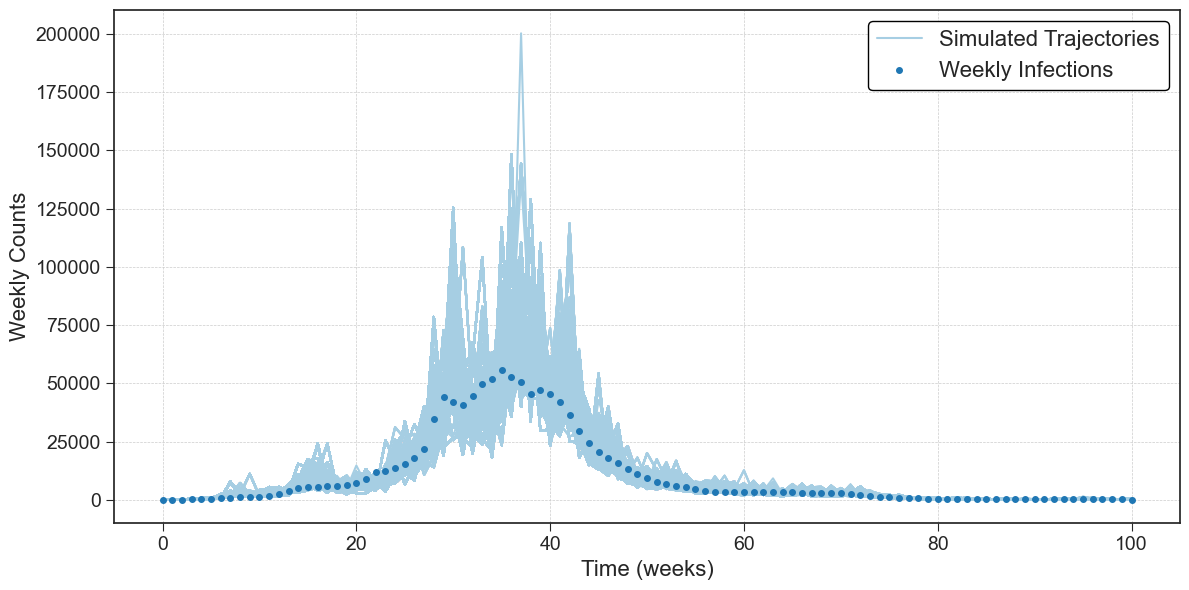

In [2488]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(1, num_particles):
    infected_trajectories = weekly_infections[ancestry_matrix[p, :].astype(int),np.arange(T+1)]
    plt.plot(infected_trajectories[:], color=colors[0])
infected_trajectories = weekly_infections[ancestry_matrix[0, :].astype(int),np.arange(T+1)]
plt.plot(infected_trajectories[:], color=colors[0], label='Simulated Trajectories')
plt.plot(aggregates[0,:], marker='o', markersize=4, linewidth=0, label='Weekly Infections')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Counts', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

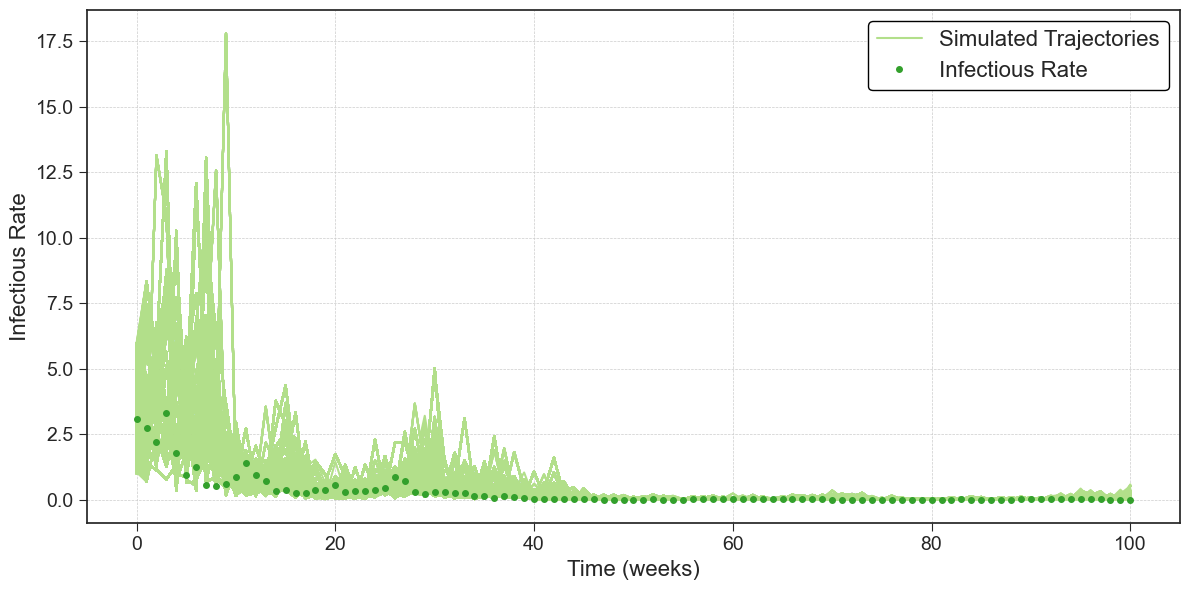

In [2489]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(1,num_particles):
    state_trajectories = particles[:,ancestry_matrix[p, :].astype(int),np.arange(T+1)]
    plt.plot(np.exp(state_trajectories[-1,:]), color=colors[2])

state_trajectories = particles[:,ancestry_matrix[0, :].astype(int),np.arange(T+1)]
plt.plot(np.exp(state_trajectories[-1,:]), color=colors[2], label='Simulated Trajectories')
    
plt.plot(np.exp(states[4,0,:]), marker='o', markersize=4, linewidth=0, color=colors[3], label='Infectious Rate')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=1)

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Infectious Rate', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

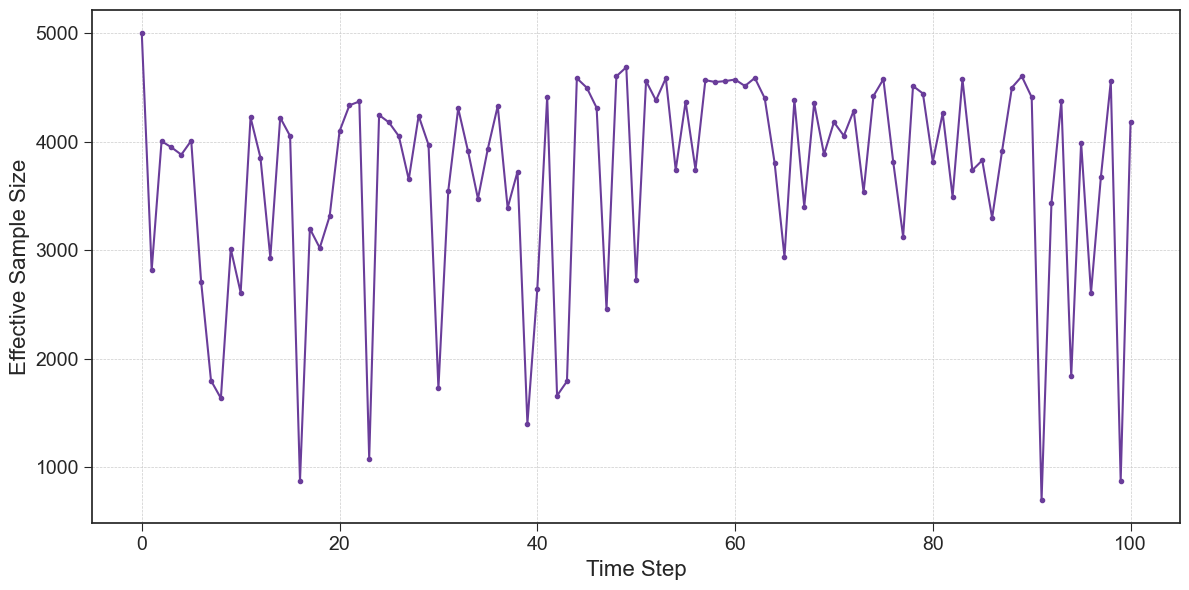

In [2490]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(ESS, marker='o', markersize=3, color=colors[-3])

plt.xlabel('Time Step', fontsize=16)
plt.ylabel('Effective Sample Size', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## PF-MCMC FOR BM_SEIR VOLATILITY

In [ ]:
theta_samples = np.zeros([current_theta.shape[0],num_iterations])
weekly_trajectories = np.zeros([T,num_iterations])
loglikelihoods = np.zeros(num_iterations)

rejected_count = 0
acceptance_count = 0
AccRate = 0

current_loglik, current_weekly  = ASIR(YO, N, T, num_particles, current_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)

print("Initial viable parameters:", current_theta)
print("Initial log-likelihood:", current_loglik)

theta_samples[:,0] = current_theta
loglikelihoods[0] = current_loglik
weekly_trajectories[:,0] = current_weekly

for i in range(1,num_iterations):
    proposed_theta = theta_samples[:, i-1] + stats.multivariate_normal(mean=np.zeros(4), cov=sigma0).rvs()
    if np.isinf(logprior(proposed_theta)):
        rejected_count += 1
        proposed_loglik = -np.inf
        accept_prob = 0
    else:
        proposed_loglik, proposed_weekly = ASIR(YO, N, T, num_particles, proposed_theta, initial_conditions, BM_SEUORDS, NB_log_likelihood)
        log_prior_ratio = logprior(proposed_theta) - logprior(theta_samples[:,i-1])
        log_lik_ratio = proposed_loglik - loglikelihoods[i-1]
        accept_prob = np.exp(min(0,log_prior_ratio + log_lik_ratio))
    
    if stats.uniform(0,1).rvs() <= accept_prob:
        theta_samples[:,i] = proposed_theta
        weekly_trajectories[:,i] = proposed_weekly
        loglikelihoods[i] = proposed_loglik
        acceptance_count += 1
    else:
        theta_samples[:,i] = theta_samples[:,i-1]
        weekly_trajectories[:,i] = weekly_trajectories[:,i-1]
        loglikelihoods[i] = loglikelihoods[i-1]
        
    AccRate = acceptance_count / (i + 1)
    if i % 100 == 0:
        print(f"Iteration {i}: Acceptance Rate = {AccRate:.2%}")
        print('Unique Samples: ', np.unique(loglikelihoods).shape[0])
        print('Rejected Samples: ', rejected_count)
        print('proposed loglik', proposed_loglik)
        print('current loglik', loglikelihoods[i-1])
        print('prior proposed', logprior(proposed_theta))
        print('current proposed', logprior(theta_samples[:,i-1]))